In [37]:
import cv2
import numpy as np
from collections import Counter

# 25개의 색상 코드를 정의합니다.
color_codes = ["#F4F0E5", "#D2C6B4", "#AE9C88", "#8E7861", "#6E5841", "#513A28", "#342113", "#180B05", "#010101", "#D7C384", "#B7A05D", "#9B7A4D", "#845B3B", "#664B2E", "#534228", "#3D2C18", "#B49C1E", "#A07429", "#8A4F2D", "#6F5232", "#4E5534", "#B26726", "#89392E", "#84432F", "#AC192A", "#AD1A2A", "#1D4F36", "#000000"]

# 위험 색상 목록을 정의합니다.
danger_colors = ["#AD1A2A",
        "#AC192A", # 빨강
        "#1D4F36",
        "#4E5534", # 초록
        "#F4F0E5", # 하양
        "#000000", # 검은색
        "#F4F0E5", # INANTION
        "#D2C6B4",
        "#AE9C88",
        "#8E7861",
        "#D7C384",
        "#B7A05D",
        "#B49C1E",
        "#342113", # Constipation
        "#180B05",
        "#010101",
        "#534228",
        "#3D2C18"]


def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(color[0], color[1], color[2])

# OpenCV에서는 BGR을 사용하지만, 여기서는 RGB로 반환합니다.
color_codes_rgb = [hex_to_rgb(code) for code in color_codes]
danger_colors_rgb = [hex_to_rgb(code) for code in danger_colors]

In [50]:
print(color_codes_rgb)

[(244, 240, 229), (210, 198, 180), (174, 156, 136), (142, 120, 97), (110, 88, 65), (81, 58, 40), (52, 33, 19), (24, 11, 5), (1, 1, 1), (215, 195, 132), (183, 160, 93), (155, 122, 77), (132, 91, 59), (102, 75, 46), (83, 66, 40), (61, 44, 24), (180, 156, 30), (160, 116, 41), (138, 79, 45), (111, 82, 50), (78, 85, 52), (178, 103, 38), (137, 57, 46), (132, 67, 47), (172, 25, 42), (173, 26, 42), (29, 79, 54), (0, 0, 0)]


In [108]:
import matplotlib.pyplot as plt
def perceptual_color_quantization(image, color_palette):
    height, width, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 색변환
    quantized_image = image.copy()  # 입력 이미지를 복사하여 양자화된 이미지를 생성
    
    white_threshold = np.array([245, 245, 245])  # 하얀색으로 간주할 임계값 설정
    
    for y in range(height):
        for x in range(width):
            pixel_color = image[y, x]
            if np.all(pixel_color >= white_threshold):  # 하얀색 배경은 처리하지 않음
                continue
            closest_color = min(color_palette, key=lambda color: np.linalg.norm(pixel_color - color))
            quantized_image[y, x] = closest_color
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image at y={y}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(quantized_image)
    plt.title(f"Quantized Image at y={y}")
    plt.axis('off')
    plt.show()
    return quantized_image

In [126]:
def analyze_image_colors(quantized_image, danger_colors):
    # 하얀색으로 간주할 임계값 설정 (예: 약간의 여유를 둠)
    white_threshold = np.array([245, 245, 245])

    # 이미지를 2차원 배열로 평평하게 만듭니다.
    flat_image = quantized_image.reshape(-1, 3)
    
    # 하얀색이 아닌 픽셀만 선택
    non_white_pixels = [tuple(pixel) for pixel in flat_image if not np.all(pixel >= white_threshold)]
    
    # 각 색상의 출현 빈도를 계산합니다.
    color_counts = Counter(non_white_pixels)
    print(color_counts)
    if not color_counts:
        # 비하얀 픽셀이 없을 경우 처리: 여기서는 None으로 반환하거나 기본값 설정
        return None, []

    # 가장 많이 나타나는 색상(대표 색상)을 찾습니다.
    most_common_color = color_counts.most_common(1)[0][0]
    
    # 위험 색상 존재 여부를 확인합니다.
    detected_danger_colors = []
    for color in danger_colors:
        if tuple(color) in color_counts:
            detected_danger_colors.append(color)
    
    return most_common_color, detected_danger_colors

In [127]:
def analyze_image(image, color_codes_rgb, danger_colors_rgb):
    # 이미지를 주어진 팔레트로 양자화
    quantized_image = perceptual_color_quantization(image, color_codes_rgb)
    
    # 양자화된 이미지에서 대표 색상과 감지된 위험 색상을 분석
    most_common_color, detected_danger_colors = analyze_image_colors(quantized_image, danger_colors_rgb)
    
    # RGB 값을 색상 코드로 변환
    most_common_color_hex = rgb_to_hex(most_common_color) if most_common_color else None
    detected_danger_colors_hex = [rgb_to_hex(color) for color in detected_danger_colors]
    
    # 결과를 반환합니다.
    return most_common_color, detected_danger_colors, most_common_color_hex, detected_danger_colors_hex


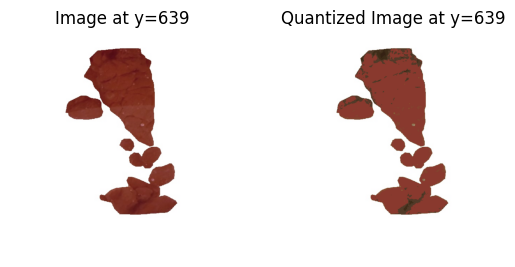

Counter({(137, 57, 46): 51135, (81, 58, 40): 6144, (132, 67, 47): 3106, (244, 240, 229): 1372, (61, 44, 24): 1176, (102, 75, 46): 473, (110, 88, 65): 443, (132, 91, 59): 218, (52, 33, 19): 182, (111, 82, 50): 164, (138, 79, 45): 102, (142, 120, 97): 63, (155, 122, 77): 26, (174, 156, 136): 10, (83, 66, 40): 1})
대표 색상: #89392e
감지된 위험 색상: ['#f4f0e5', '#f4f0e5', '#ae9c88', '#8e7861', '#342113', '#534228', '#3d2c18']


In [128]:
# 이미지를 불러옵니다.
# image = cv2.imread('/root/ai/dataset/classification_aug_apply/train/1/Type1_iter3_jpg.rf.120ab2fecf2da5c5636192b9a1f1e4af_aug_93.jpg')
image = cv2.imread("/root/ai/dataset/classification_aug_apply/train/1/Type1_iter3_jpg.rf.120ab2fecf2da5c5636192b9a1f1e4af_aug_54.jpg")
image = cv2.imread("/root/ai/dataset/classification_aug_apply/train/1/Type1_iter3_jpg.rf.120ab2fecf2da5c5636192b9a1f1e4af_aug_173.jpg")

# 이미지에서 색상 분석을 수행합니다.
mc, dc, most_common_color, detected_danger_colors = analyze_image(image, color_codes_rgb, danger_colors_rgb)

print(f"대표 색상: {most_common_color}")
print(f"감지된 위험 색상: {detected_danger_colors}")

## 대표색

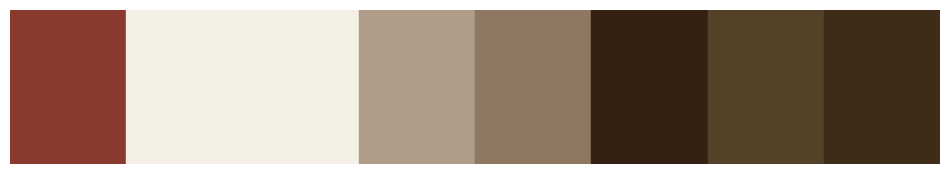

In [123]:
print(most_common_color)
print(detected_danger_colors)
# 대표 색상과 위험 색상을 하나의 리스트로 병합
all_colors = [most_common_color] + detected_danger_colors

# 각 색상을 plot으로 표시
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(all_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xlim(0, len(all_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

[(244, 240, 229), (244, 240, 229), (174, 156, 136), (142, 120, 97), (52, 33, 19), (83, 66, 40), (61, 44, 24)]
(137, 57, 46)


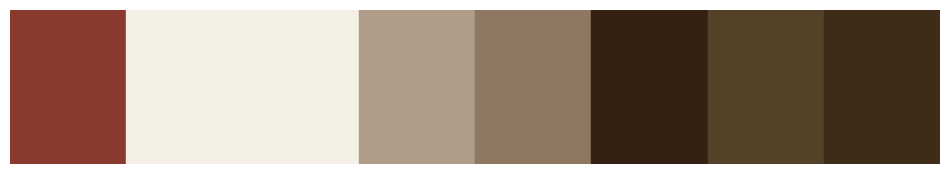

In [125]:
print(dc)
print(mc)
# 대표 색상과 위험 색상을 하나의 리스트로 병합
all_colors = [mc] + dc 

# 각 색상을 plot으로 표시
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(all_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color)/255))

ax.set_xlim(0, len(all_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

In [115]:
print(color_codes_rgb)
print(danger_colors_rgb)

[(244, 240, 229), (210, 198, 180), (174, 156, 136), (142, 120, 97), (110, 88, 65), (81, 58, 40), (52, 33, 19), (24, 11, 5), (1, 1, 1), (215, 195, 132), (183, 160, 93), (155, 122, 77), (132, 91, 59), (102, 75, 46), (83, 66, 40), (61, 44, 24), (180, 156, 30), (160, 116, 41), (138, 79, 45), (111, 82, 50), (78, 85, 52), (178, 103, 38), (137, 57, 46), (132, 67, 47), (172, 25, 42), (173, 26, 42), (29, 79, 54), (0, 0, 0)]
[(173, 26, 42), (172, 25, 42), (29, 79, 54), (78, 85, 52), (244, 240, 229), (0, 0, 0), (244, 240, 229), (210, 198, 180), (174, 156, 136), (142, 120, 97), (215, 195, 132), (183, 160, 93), (180, 156, 30), (52, 33, 19), (24, 11, 5), (1, 1, 1), (83, 66, 40), (61, 44, 24)]


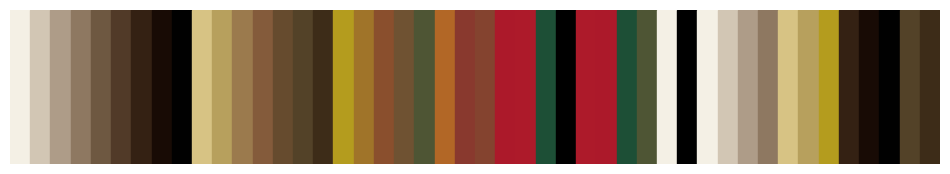

In [116]:
# 대표 색상과 위험 색상을 하나의 리스트로 병합
all_colors = color_codes_rgb + danger_colors_rgb

# 각 색상을 plot으로 표시
fig, ax = plt.subplots(figsize=(12, 2))
for i, color in enumerate(all_colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array(color)/255))

ax.set_xlim(0, len(all_colors))
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()